In [1]:
# because we noted in the first models
# that testing/validation curves were higher than training curves denoting
# a small test set (a form of underfitting), we removed regularization (dropout) and for a 
# small change in performance we were able get the curves closer together 
# representing a better fit and better generalization with unseen data 
# with this said, we may want to reinstate the dropout once the 
# model is trained with more data and we are able to train for 
# more epochs etc.

# We are selecting the vgg16 model as it has the best scores overall, does not
# seem to be favoring one class or another, has good recall on diseases
# has very well fit training and validation curves on both loss and 
# accuracy, has a robust classification report with high F1 and
# overall scores

# We want to have an idea of what the model is looking at to verify we 
# are not focusing on the wrong features

# Let's first import all necessary libraries

import tensorflow as tf
print(tf.__version__)

2.4.0


In [2]:
import pandas as pd
import numpy as np

In [3]:
import keras
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import sklearn

In [4]:
# mount drive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
# previously constructed dataframes that split the data

training_covid = pd.read_csv('/gdrive/My Drive/training_covid')
validation_covid = pd.read_csv('/gdrive/My Drive/validation_covid')
X_test_covid = pd.read_csv('/gdrive/My Drive/X_test_covid')
y_test_covid = pd.read_csv('/gdrive/My Drive/y_test_covid')

In [6]:
testing_covid = pd.concat([X_test_covid, y_test_covid], axis=1)

In [7]:
from tensorflow.keras.models import load_model

In [8]:
# Reload model from scratch this way we test our saved model

model = load_model('/gdrive/My Drive/covid_vgg16_no_reg_grad.pb')



In [9]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_col, sample_batch_size=305, batch_size=8, target_w = 224, target_h = 224):
  """
  Return generator for validation set and test test set using 
  normalization statistics from training set.

  Args:
    valid_df (dataframe): dataframe specifying validation data.
    test_df (dataframe): dataframe specifying test data.
    train_df (dataframe): dataframe specifying training data.
    image_dir (str): directory where image files are held.
    x_col (str): name of column in df that holds filenames.
    y_cols (list): list of strings that hold y labels for images.
    sample_size (int): size of sample to use for normalization statistics.
    batch_size (int): images per batch to be fed into model during training.
    seed (int): random seed.
    target_w (int): final width of input images.
    target_h (int): final height of input images.
    
  Returns:
      test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """

  # create validation set using normalization statistics from
  # the training set only

  print("\nSampling normalization statistics from training only...\n")

  
  
  # Flow from directory with specified batch size and target image size
  sample_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory='/gdrive/My Drive/XRaysCombo',
        x_col=x_col, # features
        y_col=y_col, # labels
        class_mode='categorical', # 3 classes
        batch_size= batch_size, # images per batch
        shuffle=True, # shuffle the rows or not
        target_size=(target_w, target_h) # width and height of output image this one matches RESNET50
  
  )
  # get data sample
  batch = sample_generator.next()
  data_sample = batch[0]


  # generator fitted with training set only

  # use sample to fit mean and std for test set generator
  test_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
  
  test_datagen.fit(data_sample)


  print("\nPreparing validation dataset...\n")

  # Flow from directory with specified batch size and target image size
  validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory='/gdrive/My Drive/XRaysCombo',
        x_col=x_col, # features
        y_col= y_col, # labels
        class_mode='categorical', # 3 classes
        batch_size= batch_size, # images per batch
        shuffle=False, # shuffle the rows or not
        target_size=(target_w, target_h) # width and height of output image this one matches RESNET50
  )

  print("\nPreparing testing dataset...\n")

  # Flow from directory with specified batch size and target image size
  test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='/gdrive/My Drive/XRaysCombo',
        x_col=x_col, # features
        y_col=y_col, # labels
        class_mode='categorical', # 3 classes
        batch_size= batch_size, # images per batch
        shuffle=False, # shuffle the rows or not
        target_size=(target_w, target_h) # width and height of output image this one matches RESNET50
  )
  return validation_generator, test_generator

In [10]:

import os
from keras.preprocessing.image import ImageDataGenerator

# Recall that the images were moved to a folder names XRays. 
image_dir = '/gdrive/MyDrive/XRaysCombo' 

In [11]:
train_df = training_covid 
valid_df = validation_covid
test_df = testing_covid
x_col = "FILE NAME"
y_col = 'Class'

valid_generator, test_generator = get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_col)


Sampling normalization statistics from training only...

Found 305 validated image filenames belonging to 3 classes.

Preparing validation dataset...

Found 54 validated image filenames belonging to 3 classes.

Preparing testing dataset...

Found 40 validated image filenames belonging to 3 classes.


In [12]:
# re-checking predictions with unseen test data 
prediction = model.predict(test_generator, steps = len(test_generator))

In [13]:
y_pred = np.argmax(prediction, axis = 1)
y_pred

array([2, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 1, 1, 1, 1, 2, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 2, 2, 0, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 2])

In [14]:
# make a list of the class names
class_names = ['COVID-19', 'Normal', 'Viral Pneumonia']

In [15]:
# convert test entries to integers for comparison with predictions
classcategories = {'COVID-19': 0,'Normal':1,'Viral Pneumonia':2}
y_test_covid['y_true'] = [classcategories[x] for x in y_test_covid['Class']]
y_test_covid['y_true'].value_counts()

2    14
1    13
0    13
Name: y_true, dtype: int64

In [16]:
# true values
y_test = y_test_covid['y_true'].values
y_test

array([2, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 1, 1, 1, 1, 2, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 2, 2, 0, 1, 2, 2, 2, 1, 0, 1, 0, 0, 0, 0, 2])

Confusion matrix, without normalization
[[13  0  0]
 [ 1 12  0]
 [ 0  0 14]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.08 0.92 0.  ]
 [0.   0.   1.  ]]


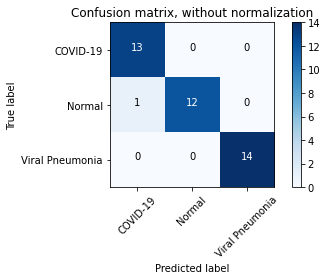

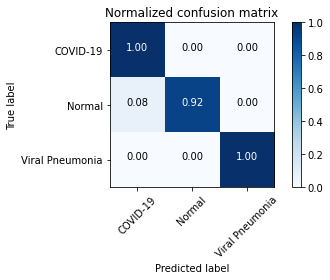

In [17]:
# confusion matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")

In [18]:
# reproducibility of test results looks great after re-calculating
# the statistics on a saved model but what type of features is the
# model focusing on to produce these metrics?


from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=class_names))

                 precision    recall  f1-score   support

       COVID-19       0.93      1.00      0.96        13
         Normal       1.00      0.92      0.96        13
Viral Pneumonia       1.00      1.00      1.00        14

       accuracy                           0.97        40
      macro avg       0.98      0.97      0.97        40
   weighted avg       0.98      0.97      0.97        40



In [19]:
# create functions to use gradcam (Gradient-weighted Class Activation Mapping)
# to identify our network is focusing on the right areas using a visual heatmap
# of activation gradients

def grad_cam(input_model, image, category_index, layer_name, eps=1e-8, alpha=0.5):
  
  gradModel = Model(
        inputs=[input_model.inputs],
        outputs=[input_model.get_layer(layer_name).output,
                 input_model.output])
  
  with tf.GradientTape() as tape:
    inputs = tf.cast(image, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, category_index]

  grads = tape.gradient(loss, convOutputs)


  castConvOutputs = tf.cast(convOutputs > 0, "float32")
  castGrads = tf.cast(grads > 0, "float32")
  guidedGrads = castConvOutputs * castGrads * grads


  convOutputs = convOutputs[0]
  guidedGrads = guidedGrads[0]

  weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
  cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
  (w, h) = (image.shape[2], image.shape[1])
  heatmap = cv2.resize(cam.numpy(), (w, h))

	# normalize the heatmap such that all values lie in the range
	# [0, 1], scale the resulting values to the range [0, 255],
	# and then convert to an unsigned 8-bit integer
  numer = heatmap - np.min(heatmap)
  denom = (heatmap.max() - heatmap.min()) + eps
  heatmap = numer / denom
  heatmap = (heatmap * 255).astype("uint8")
	# return the resulting heatmap to the calling function
  return heatmap

def overlay_heatmap(heatmap, image, alpha=0.5,
	colormap=cv2.COLORMAP_VIRIDIS):
	# apply the supplied color map to the heatmap and then
	# overlay the heatmap on the input image
	heatmap = cv2.applyColorMap(heatmap, colormap)
	output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

	# return a 2-tuple of the color mapped heatmap and the output,
	# overlaid image
	return (heatmap, output)
		

def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [20]:
def get_mean_std_per_batch(df, H=224, W=224):
    sample_data = []
    for idx, img in enumerate(df.sample(305)["FILE NAME"].values):
        path = image_dir + "/" + img
        sample_data.append(np.array(image.load_img(path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std    

def load_image_normalize(path, mean, std, H=224, W=224):
    x = image.load_img(path, target_size=(H, W))
    x -= mean
    x /= std
    x = np.expand_dims(x, axis=0)
    return x

def load_image(path, df, preprocess=True, H = 224, W = 224):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        mean, std = get_mean_std_per_batch(df, H=H, W=W)
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

In [21]:
# Take a look at the model architecture to select the convolutional
# layer closest to the end 

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [22]:
image_dir = '/gdrive/MyDrive/XRaysCombo' 

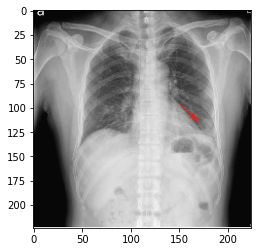

In [23]:
# Let's start with Covid 19

from keras.preprocessing import image

df = training_covid
im_path = image_dir + '/COVID-19 (83).png'
x = load_image(im_path, df, preprocess=False)
plt.imshow(x, cmap = 'gray')
plt.show()

In [24]:
mean, std = get_mean_std_per_batch(df)

In [25]:
print("mean: ", mean)
print("std: ", std)

mean:  97.95669244260205
std:  55.547927804877936


In [26]:
# confirm we can get the last layer
model.get_layer('block5_conv3')

In [27]:
from tensorflow.keras import Model

im = load_image_normalize(im_path, mean, std)
cam = grad_cam(model, im, 0, 'block5_conv3') # covid 19 is class 0

In [29]:
orig = cv2.imread(image_dir + '/COVID-19 (83).png')

In [30]:
orig.shape

(1024, 1024, 3)

In [31]:
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(cam, (orig.shape[1], orig.shape[0]))
(heatmap, output) = overlay_heatmap(heatmap, orig, alpha=0.5)

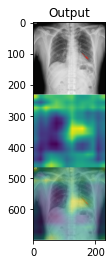

In [32]:
# display the original image and resulting heatmap and output image
# this is how the overlays will be created

import imutils

output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
plt_imshow("Output", output)

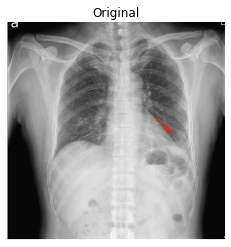

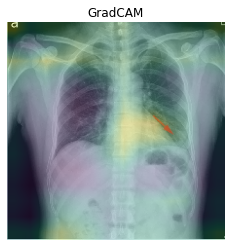

In [33]:
# Original Covid Image and Image Showing Activations
# Activated Regions are brighter (bright yellow if you use Viridis
# but that is just the default, you can include the
# cmap argument on plt.imshow and change it
# I do like viridis, I think it works well on this task)

# one can set the alpha higher to the default of 0.5
# if you want the color brighter
# but I like a slightly lower alpha so that we can see 
# what's behind or surrounding the activations.

plt.imshow(load_image(im_path, df, preprocess=False), cmap='gray')
plt.title("Original")
plt.axis('off')

plt.show()

plt.imshow(load_image(im_path, df, preprocess=False), cmap='gray')
plt.imshow(cam, alpha=0.3)
plt.title("GradCAM")
plt.axis('off')
plt.show()

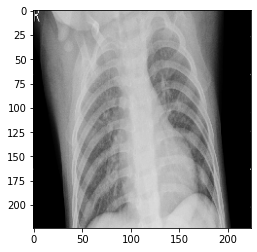

In [34]:
# Note that the light yellow regions are mapping to
# areas of the anatomy, but for example this red arrow
# I feel is distracting, we want to make sure activations
# are not being triggered by these markings, it doesn't
# look like markings outside the body region would be a 
# problem but inside the body they are in the least a 
# distraction if possible the images for analysis should
# be saved prior to marking

# Now let's look at Viral Pneumonia

from keras.preprocessing import image

df = training_covid
im_path = image_dir + '/Viral Pneumonia (751).png'
x = load_image(im_path, df, preprocess=False)
plt.imshow(x, cmap = 'gray')
plt.show()

In [35]:
from tensorflow.keras import Model

im = load_image_normalize(im_path, mean, std)
cam = grad_cam(model, im, 2, 'block5_conv3') # viral pneumonia is class 2

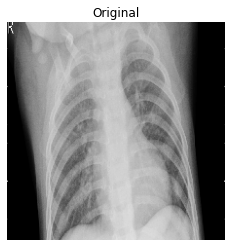

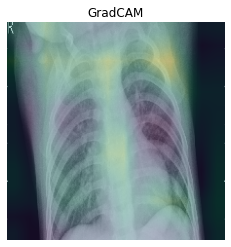

In [36]:
plt.imshow(load_image(im_path, df, preprocess=False), cmap='gray')
plt.title("Original")
plt.axis('off')

plt.show()

plt.imshow(load_image(im_path, df, preprocess=False), cmap='gray')
plt.imshow(cam, alpha=0.3)
plt.title("GradCAM")
plt.axis('off')
plt.show()

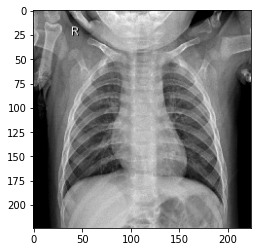

In [37]:
# Note the yellow regions more prominent on the top right

# Now let's look at Normal Lungs

from keras.preprocessing import image

df = training_covid
im_path = image_dir + '/NORMAL (214).png'
x = load_image(im_path, df, preprocess=False)
plt.imshow(x, cmap = 'gray')
plt.show()

In [38]:
from tensorflow.keras import Model

im = load_image_normalize(im_path, mean, std)
cam = grad_cam(model, im, 1, 'block5_conv3') # normal is class 1

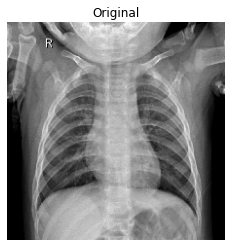

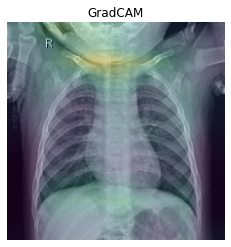

In [39]:
plt.imshow(load_image(im_path, df, preprocess=False), cmap='gray')
plt.title("Original")
plt.axis('off')

plt.show()

plt.imshow(load_image(im_path, df, preprocess=False), cmap='gray')
plt.imshow(cam, alpha=0.3)
plt.title("GradCAM")
plt.axis('off')
plt.show()

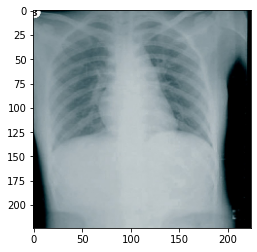

In [40]:
# More Covid

from keras.preprocessing import image

df = training_covid
im_path = image_dir +  '/COVID-19 (101).png' 
x = load_image(im_path, df, preprocess=False)
plt.imshow(x, cmap = 'gray')
plt.show()

In [41]:
from tensorflow.keras import Model

im = load_image_normalize(im_path, mean, std)
cam = grad_cam(model, im, 0, 'block5_conv3') # covid 19 is class 0

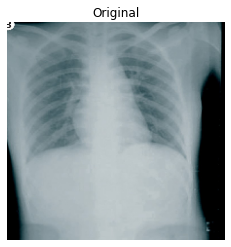

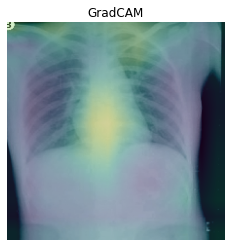

In [42]:
# A few more Covid images

plt.imshow(load_image(im_path, df, preprocess=False), cmap='gray')
plt.title("Original")
plt.axis('off')

plt.show()

plt.imshow(load_image(im_path, df, preprocess=False), cmap='gray')
plt.imshow(cam, alpha=0.3)
plt.title("GradCAM")
plt.axis('off')
plt.show()

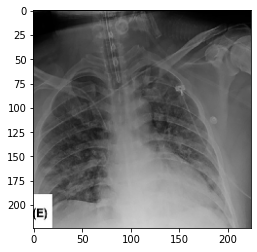

In [43]:
from keras.preprocessing import image

df = training_covid
im_path = image_dir + '/COVID-19 (97).png'
x = load_image(im_path, df, preprocess=False)
plt.imshow(x, cmap = 'gray')
plt.show()

In [44]:
from tensorflow.keras import Model

im = load_image_normalize(im_path, mean, std)
cam = grad_cam(model, im, 0, 'block5_conv3') # covid 19 is class 0

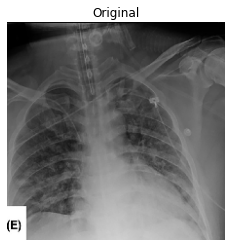

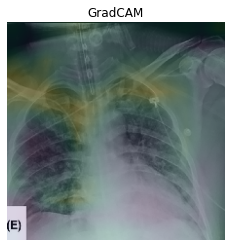

In [45]:
plt.imshow(load_image(im_path, df, preprocess=False), cmap='gray')
plt.title("Original")
plt.axis('off')

plt.show()

plt.imshow(load_image(im_path, df, preprocess=False), cmap='gray')
plt.imshow(cam, alpha=0.2)
plt.title("GradCAM")
plt.axis('off')
plt.show()

In [ ]:
# We can see from the bright yellow areas that layer activations appear to be occuring
# around areas of the anatomy rather than electrodes or other artifacts, with this said
# I think it is important in the future to keep the images to just the anatomy and no
# markings or foreign objects if possible (note that two of the covid images I've shown, 
# the first one with the gradients and this very last one, do have either an arrow
# marking on top or this one has an electrode in the path of the gradient, it certainly 
# doesn't look like we have systematic electrodes in covid cases or systematic arrows
# but we shouldn't risk it on a diagnostic tool). I would expect the code to be reviewed
# by a team of data scientists, and then a team of doctors would also review these
# activations to make sure for each disease or non disease the activations make sense, it
# does appear that these activations are focused on anatomical areas the model has learned from
# the feature extractions and not letters or artifacts. This should improve over time
# and all three classes should achieve very solid scores. Now, let's imagine that there was
# an immediate need for this classifier, after approval from the technical team and
# a team of doctors, then we would feel more confident about deployment. We'll do a mock
# deployment next remembering all the rigorous checking from multiple experts that
# the model has to go through before we even think about that.